In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

In [2]:
#define paths
models_path = r"C:/Users/T-x23/Downloads/Mini_project_Covid19/models/"

covid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_COVID"
noncovid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_NonCOVID"


# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [3]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_NonCOVID')

In [4]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [6]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [7]:
vggModel.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [8]:
batch_size=32
epochs=200

In [9]:
hist= model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Train for 23.5 steps, validate on 188 samples
Epoch 1/200
24/23 [==============================] - 17s 713ms/step - loss: 1.0592 - accuracy: 0.5691 - val_loss: 0.7261 - val_accuracy: 0.6170loss: 1.277
Epoch 2/200
24/23 [==============================] - 12s 492ms/step - loss: 0.7227 - accuracy: 0.6596 - val_loss: 0.4433 - val_accuracy: 0.8032
Epoch 3/200
24/23 [==============================] - 12s 507ms/step - loss: 0.5490 - accuracy: 0.7420 - val_loss: 0.3764 - val_accuracy: 0.8404
Epoch 4/200
24/23 [==============================] - 12s 515ms/step - loss: 0.4655 - accuracy: 0.7912 - val_loss: 0.3068 - val_accuracy: 0.8989
Epoch 5/200
24/23 [==============================] - 12s 492ms/step - loss: 0.4884 - accuracy: 0.7713 - val_loss: 0.3336 - val_accuracy: 0.8617
Epoch 6/200
24/23 [==============================] - 13s 527ms/step - loss: 0.4142 - accuracy: 0.8005 - val_loss: 0.2799 - val_accuracy: 0.8777
Epoch 7/200
24/23 [==============================] - 13s 531ms/step - loss: 0.4

Epoch 57/200
24/23 [==============================] - 13s 544ms/step - loss: 0.3672 - accuracy: 0.8617 - val_loss: 0.2737 - val_accuracy: 0.8830
Epoch 58/200
24/23 [==============================] - 13s 536ms/step - loss: 0.3494 - accuracy: 0.8564 - val_loss: 0.3205 - val_accuracy: 0.8777
Epoch 59/200
24/23 [==============================] - 13s 531ms/step - loss: 0.3947 - accuracy: 0.8511 - val_loss: 0.3052 - val_accuracy: 0.8617
Epoch 60/200
24/23 [==============================] - 13s 552ms/step - loss: 0.3088 - accuracy: 0.8723 - val_loss: 0.2379 - val_accuracy: 0.9096
Epoch 61/200
24/23 [==============================] - 14s 573ms/step - loss: 0.3315 - accuracy: 0.8737 - val_loss: 0.4516 - val_accuracy: 0.7979
Epoch 62/200
24/23 [==============================] - 14s 576ms/step - loss: 0.3968 - accuracy: 0.8404 - val_loss: 0.2018 - val_accuracy: 0.9149
Epoch 63/200
24/23 [==============================] - 13s 547ms/step - loss: 0.3116 - accuracy: 0.8830 - val_loss: 0.2070 - val_ac

24/23 [==============================] - 15s 623ms/step - loss: 0.4085 - accuracy: 0.8590 - val_loss: 0.6089 - val_accuracy: 0.7819
Epoch 170/200
24/23 [==============================] - 14s 566ms/step - loss: 0.3385 - accuracy: 0.8763 - val_loss: 0.1849 - val_accuracy: 0.9521
Epoch 171/200
24/23 [==============================] - 14s 600ms/step - loss: 0.2901 - accuracy: 0.8896 - val_loss: 0.1850 - val_accuracy: 0.9149
Epoch 172/200
24/23 [==============================] - 14s 566ms/step - loss: 0.3209 - accuracy: 0.8763 - val_loss: 0.1860 - val_accuracy: 0.9149
Epoch 173/200
24/23 [==============================] - 14s 598ms/step - loss: 0.4529 - accuracy: 0.8511 - val_loss: 0.1772 - val_accuracy: 0.9521
Epoch 174/200
24/23 [==============================] - 14s 573ms/step - loss: 0.4015 - accuracy: 0.8564 - val_loss: 0.2337 - val_accuracy: 0.9043
Epoch 175/200
24/23 [==============================] - 14s 574ms/step - loss: 0.3018 - accuracy: 0.8949 - val_loss: 0.1883 - val_accuracy:

In [10]:
model.save(models_path+'vgg_chest.h5')

In [11]:
model.save_weights(models_path+'vggweights_chest.hdf5')

In [12]:
model = load_model(models_path+'vgg_chest.h5')

In [13]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=32)
scores

188/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.19695294220396814, 0.9361702]

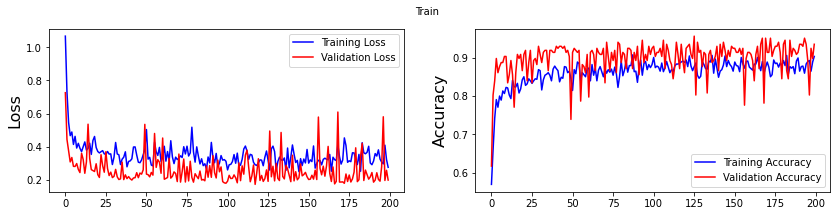

In [14]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Train', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### **Making Predicions**

In [15]:
y_pred = model.predict(X_test, batch_size=batch_size)

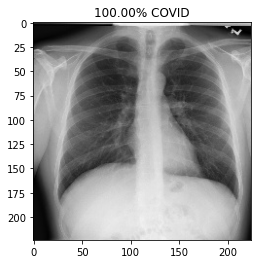

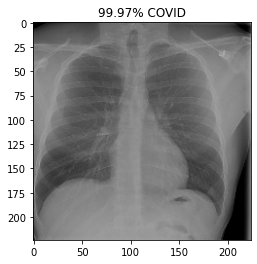

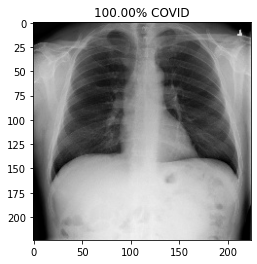

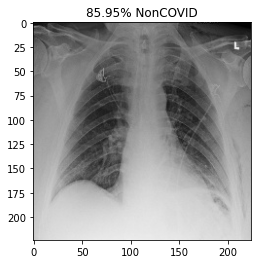

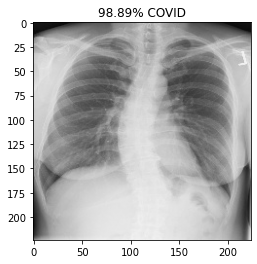

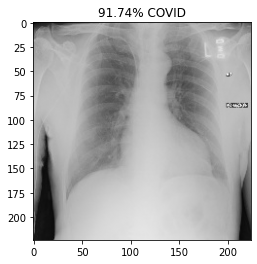

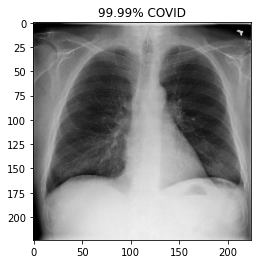

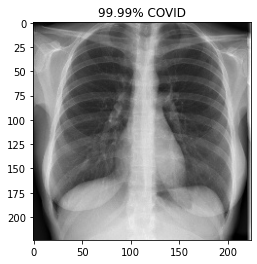

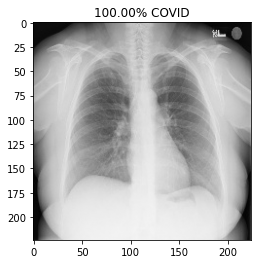

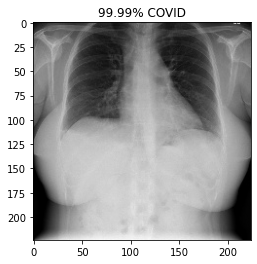

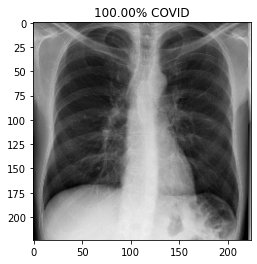

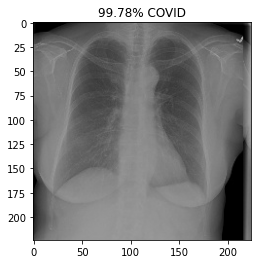

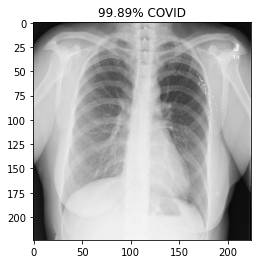

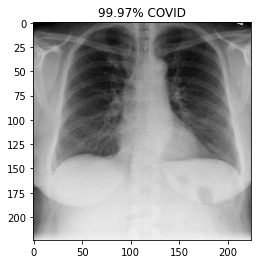

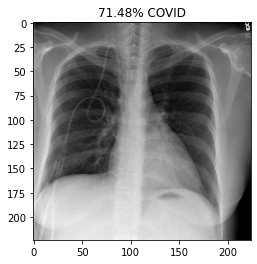

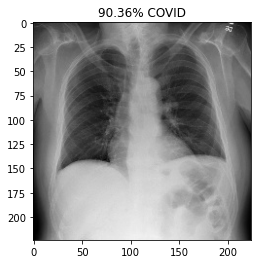

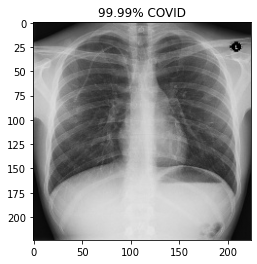

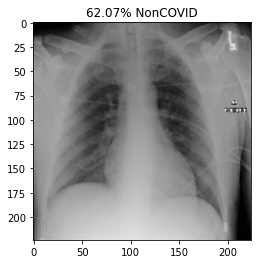

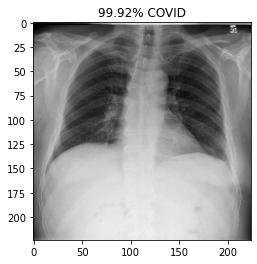

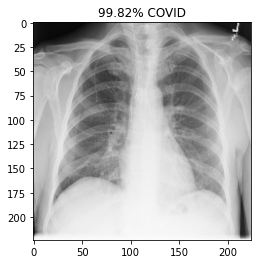

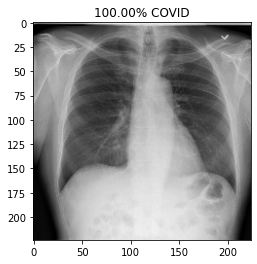

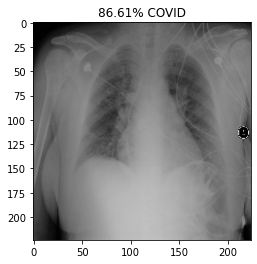

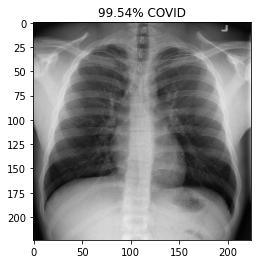

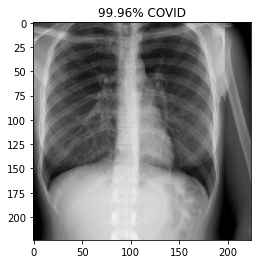

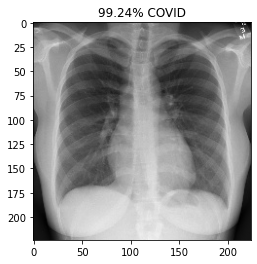

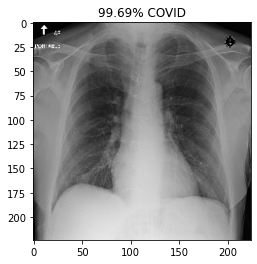

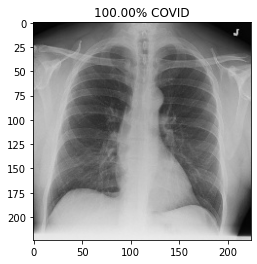

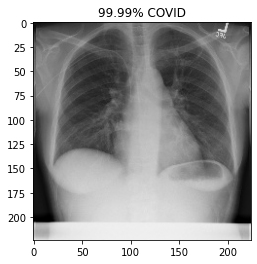

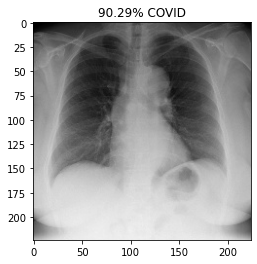

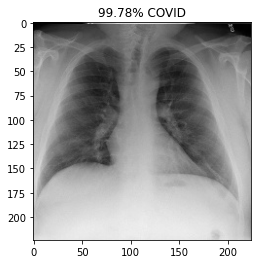

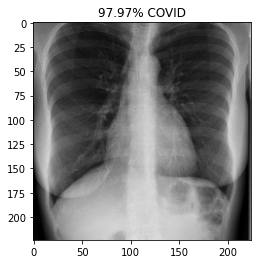

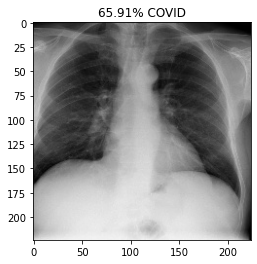

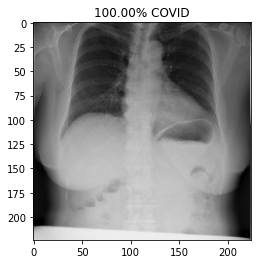

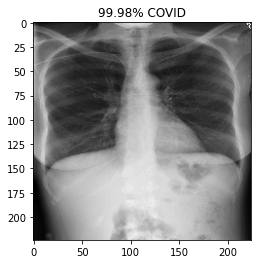

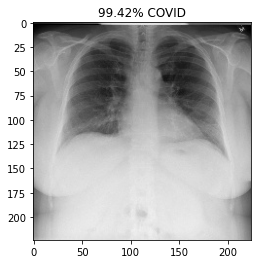

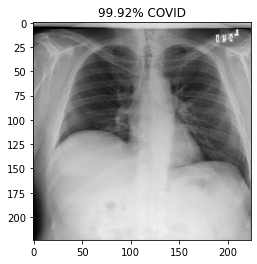

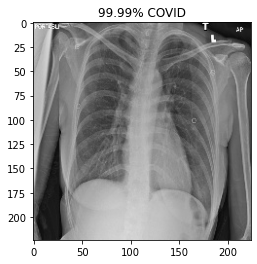

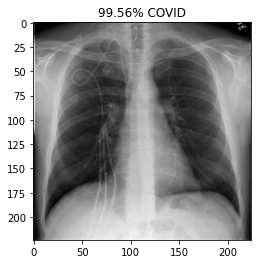

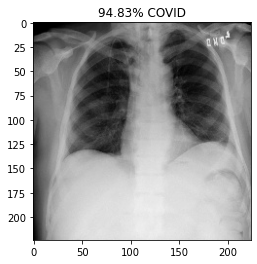

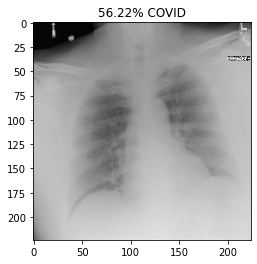

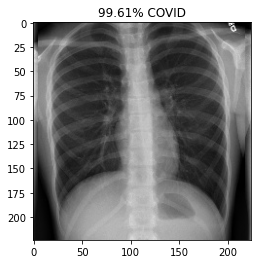

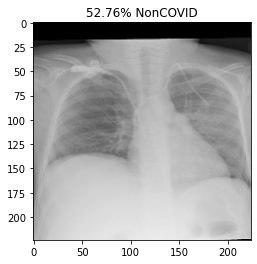

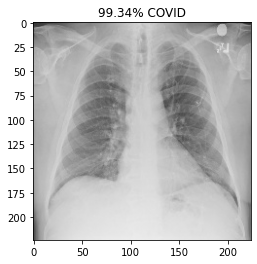

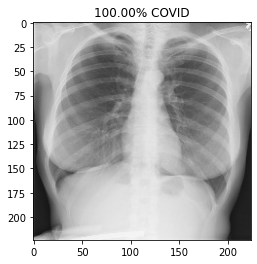

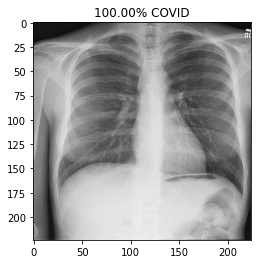

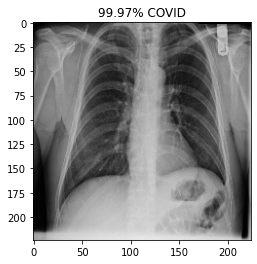

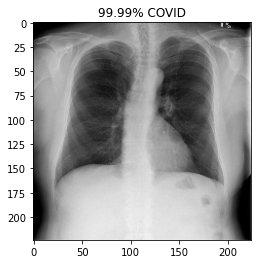

In [16]:
prediction=y_pred[0:47]
for index, probability in enumerate(prediction):
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
    plt.imshow(X_test[index])
    plt.show()

In [17]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### **Classification Report**

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        87
           1       0.92      0.96      0.94       101

    accuracy                           0.94       188
   macro avg       0.94      0.93      0.94       188
weighted avg       0.94      0.94      0.94       188



In [22]:
confusion_matrix

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

Text(0.5, 1.0, 'VGG -19 Model ')

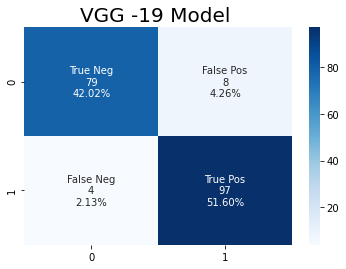

In [23]:
cf_matrix = confusion_matrix(y_test_bin,y_pred_bin)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.title("VGG -19 Model ", fontsize =20)

Text(0.5, 1.0, 'VGG -19 Model ')

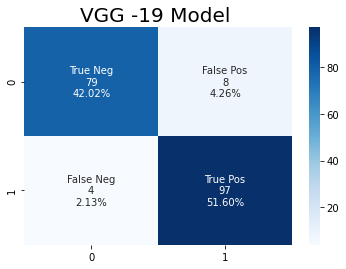

In [25]:
cf_matrix = confusion_matrix(y_test_bin,y_pred_bin)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
#group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
#group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.title("VGG -19 Model ", fontsize =20)

<AxesSubplot:>

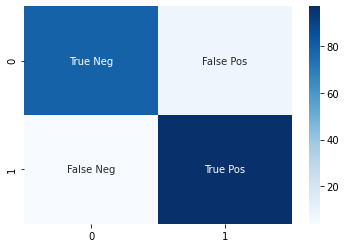

In [26]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')